# LSTM - Time Serise Dataset

* 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
* https://data.kma.go.kr/cmmn/main.do
* 기후통계분석 -> 기온분석 -> 기간(20110101~20191231) -> 검색 -> CSV 다운로드
* Seoul_Temp.csv

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Packages

* Packages

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# I. File

In [3]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [4]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


# II. Data Preprocessing

> ## 1) 일일 평균온도('avg') 변화 시각화

* 일일 평균온도 변화에 일정한 패턴 확인

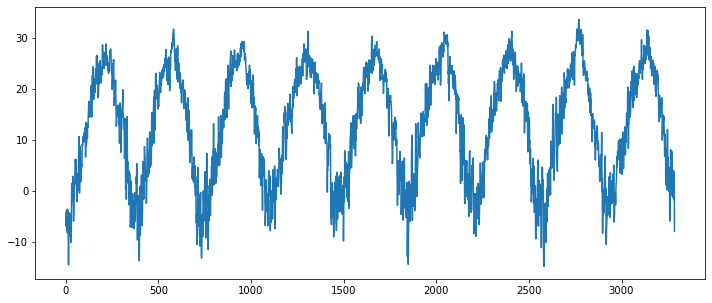

In [5]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

* tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [6]:
scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

> ## 3) Train vs. Test Split

* Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
* Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일

In [7]:
train = temp_data[0:2557]
test  = temp_data[2557:]

# III. 시계열 데이터 처리 함수

> ## 1) 시계열 학습용 데이터 생성 함수 정의

* X : 학습 평균온도 데이터
* y : 정답 평균온도 데이터
* 일정 기간의 X로 y를 예측하도록 학습

In [8]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

> ## 2) loop_back 기간 설정 후 학습데이터 생성

* 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [9]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

In [10]:
train_X[0]

array([-0.67010309, -0.61237113, -0.57525773, -0.55051546, -0.55463918,
       -0.70309278, -0.67835052, -0.53814433, -0.67835052, -0.72783505,
       -0.61237113, -0.72783505, -0.63298969, -0.54639175, -0.89278351,
       -0.98762887, -0.78969072, -0.66597938, -0.66185567, -0.72783505,
       -0.67010309, -0.56701031, -0.57525773, -0.75257732, -0.73608247,
       -0.74020619, -0.75670103, -0.71546392, -0.76494845, -0.80618557,
       -0.64536082, -0.39793814, -0.33608247, -0.32783505, -0.34020619,
       -0.3443299 , -0.37731959, -0.37731959, -0.27010309, -0.43917526,
       -0.47628866, -0.50927835, -0.63298969, -0.58762887, -0.52989691,
       -0.46391753, -0.41443299, -0.35257732, -0.32371134, -0.33195876,
       -0.17113402, -0.13402062, -0.13402062, -0.15876289, -0.13814433,
       -0.30721649, -0.13402062, -0.21649485, -0.2742268 , -0.36907216,
       -0.47628866, -0.47628866, -0.38556701, -0.30309278, -0.24948454,
       -0.32371134, -0.32371134, -0.3814433 , -0.33195876, -0.2 

# IV. LSTM Modeling

> ## 1) Model Define

In [11]:
model = Sequential()
model.add(Dense(64, 
               input_shape = (180,)))
model.add(Dense(1, activation = 'tanh'))

* Model Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                11584     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 11,649
Trainable params: 11,649
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

In [13]:
model.compile(loss = 'mean_squared_error', 
              optimizer = 'adam')

> ## 3) Model Fit

* 약 5분

In [14]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200, 
                 batch_size = 16,  
                 validation_data = (test_X, test_y))

Epoch 1/200
149/149 [==============================] - 1s 2ms/step - loss: 0.0489 - val_loss: 0.0245
Epoch 2/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0200 - val_loss: 0.0164
Epoch 3/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0193 - val_loss: 0.0139
Epoch 4/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0145 - val_loss: 0.0138
Epoch 5/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0117
Epoch 6/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0101
Epoch 7/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 8/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0127
Epoch 9/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0171
Epoch 10/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0114 - val_lo

149/149 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0097
Epoch 82/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 83/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 84/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0095
Epoch 85/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 86/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0090
Epoch 87/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0108
Epoch 88/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 89/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 90/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 

Epoch 161/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0093
Epoch 162/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0106
Epoch 163/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0093
Epoch 164/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 165/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0104
Epoch 166/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0106
Epoch 167/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 168/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 169/200
149/149 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 170/200
149/149 [==============================] - 0s 2ms/step - lo

> ## 4) 학습결과 시각화

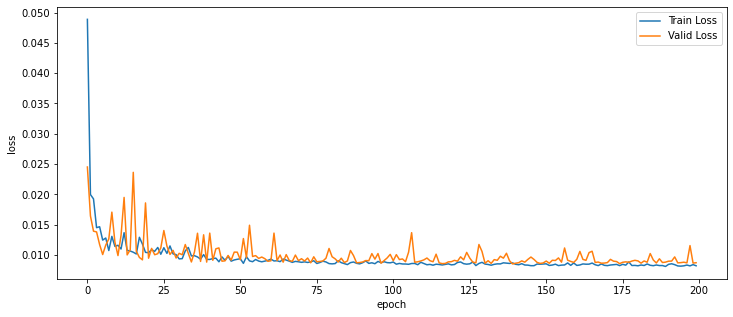

In [15]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [16]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  0.007766081020236015
Test Score:  0.008725888095796108


# V. Model Predict

1. 예측한 값으로 다음을 또 예측

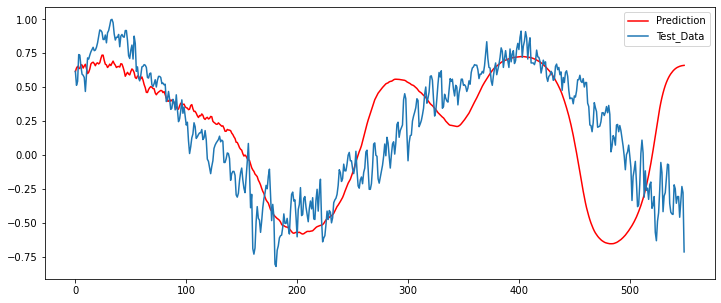

In [41]:
look_ahead = 550

xhat = test_X[0].reshape(1, -1)

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(xhat)
    predictions[i] = prediction
    xhat = np.array(np.append(xhat[0][1:], prediction)).reshape(1, -1)
    
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

2. 그냥 예측

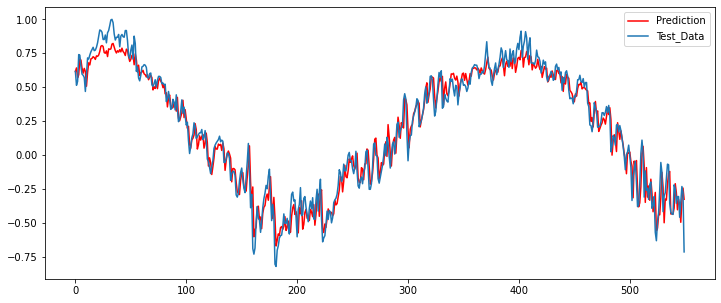

In [42]:
look_ahead = 550

xhat = test_X

predictions = model.predict(xhat)
    
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()